In [2]:
import os

import gymnasium as gym
import mediapy as media
import numpy as np
import seaborn as sns
import torch
from tqdm import tqdm
import wandb

from legato.nets import *
from legato.sampler import *

In [3]:
# Set mujoco to use EGL
os.environ["MUJOCO_GL"] = "egl"

In [4]:
# Download files from a past wandb run
run_id = "bple4jb0"
for name in [
    "state_encoder.pt",
    "action_encoder.pt",
    "transition_model.pt",
    "state_decoder.pt",
    "action_decoder.pt",
    "indices.npz",
]:
    wandb.restore(
        f"trained_net_params/{name}",
        run_path=f"mishmish66/legato/{run_id}",
        replace=True,
        root="../",
    )

In [5]:
# Load models
state_encoder = torch.load('../trained_net_params/state_encoder.pt')
action_encoder = torch.load('../trained_net_params/action_encoder.pt')
transiton_model = torch.load('../trained_net_params/transition_model.pt')
state_decoder = torch.load('../trained_net_params/state_decoder.pt')
action_decoder = torch.load('../trained_net_params/action_decoder.pt')

In [6]:
action_space_size = 1.0

In [51]:
# Now let's optimize a trajectory
def unhuber(x, y):
    l1 = torch.norm(x - y, p=1, dim=-1)
    l2 = torch.norm(x - y, p=2, dim=-1).square()
    return torch.maximum(l1, l2)


actor = ActorPolicy(
    2,
    action_space_size,
    state_encoder,
    transiton_model,
    state_decoder,
    action_decoder,
    optim_factory=torch.optim.AdamW,
    # loss_func=unhuber,
    loss_func=torch.nn.MSELoss(reduction="none"),
    lr=0.1,
    decay=1.0,
    horizon=1024,
    iters=64,
    # tail_states=4,
    discount=0.995,
).cuda()

# actor = torch.compile(actor)
episode_len = 128

parallel_env_count = 8
# Make parallel env
envs = gym.vector.make(
    "PointMaze_Medium-v3",
    num_envs=parallel_env_count,
    asynchronous=True,
    render_mode="rgb_array",
    continuing_task=True,
    max_episode_steps=episode_len,
    reset_target=True,
)

obses, infos = envs.reset()
states = torch.tensor(obses["observation"], dtype=torch.float32, device="cuda")

latent_action_plan = None

initial_state = states

traj_actions = []
traj_states = [initial_state]

frame_stacks = [[frame] for frame in envs.call("render")]

skips = 1

loss_curves = []
for i in tqdm(range(episode_len), disable=True):

    if i % skips == 0:
        target_states = torch.zeros(
            (parallel_env_count, 4), dtype=torch.float32, device="cuda"
        )
        desired_goals = torch.tensor(
            obses["desired_goal"], dtype=torch.float32, device="cuda"
        )
        target_states[:, :2] = desired_goals

        horizon_len = min(128, episode_len - i)
        horizons = torch.ones(parallel_env_count, device="cuda") * horizon_len
        next_actions, latent_action_plan, loss_curve = actor(
            states, target_states, horizons, None, return_curve=True
            # states, target_states, horizons, latent_action_plan, return_curve=True
        )

    else:
        next_latent_act = latent_action_plan[..., 0, :]
        latent_action_plan = latent_action_plan[..., 1:, :]

        latent_states = state_encoder(states)
        next_actions = action_decoder((next_latent_act, latent_states)).detach()

    loss_curves.append(loss_curve)
    obses, rew, term, trunc, info = envs.step(next_actions.cpu().numpy())
    states = torch.tensor(obses["observation"], dtype=torch.float32, device="cuda")

    traj_actions.append(next_actions)
    traj_states.append(obses["observation"])

    for frame_stack, frame in zip(frame_stacks, envs.call("render")):
        frame_stack.append(frame)

    if i % skips in [skips - 1, 0, 1]:
        print(
            f"Iteration {i}, {i % skips} after skip, action: {next_actions[0].cpu().numpy()}"
        )

# traj_actions = torch.stack(traj_actions, dim=1)
# traj_states = torch.tensor(states, dtype=torch.float32, device="cuda")

/home/mishmish/Documents/venvs/legato_simple/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(


0.07488493621349335
Iteration 0, 0 after skip, action: [0.2658041  0.00146246]
0.07900359481573105
Iteration 1, 0 after skip, action: [-0.42998052  1.2624397 ]
0.08638110011816025
Iteration 2, 0 after skip, action: [0.15469609 0.580809  ]
0.05158325284719467
Iteration 3, 0 after skip, action: [0.33372986 0.6076354 ]
0.05210656300187111
Iteration 4, 0 after skip, action: [1.0304425  0.16336884]
0.07886787503957748
Iteration 5, 0 after skip, action: [2.5599751 0.8832046]
0.05435985326766968
Iteration 6, 0 after skip, action: [3.3189018  0.10486207]
0.05899111181497574
Iteration 7, 0 after skip, action: [0.8735696  0.08829601]
0.08780578523874283
Iteration 8, 0 after skip, action: [ 2.4956145 -0.0295859]
0.07964245229959488
Iteration 9, 0 after skip, action: [0.6054009  0.13569869]
0.06384626030921936
Iteration 10, 0 after skip, action: [0.10534577 0.79591525]
0.025355752557516098
Iteration 11, 0 after skip, action: [0.7846203  0.85085547]
0.03232073783874512
Iteration 12, 0 after skip, a

<Axes: >

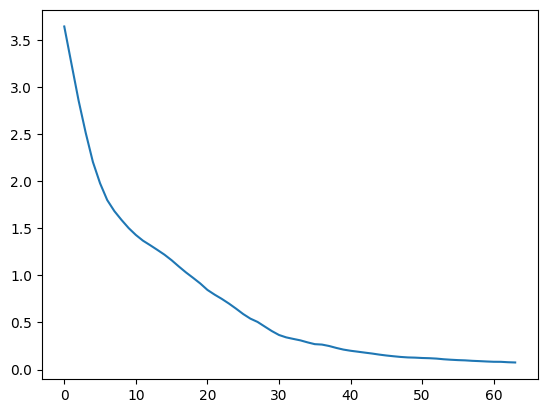

In [52]:
curve = loss_curves[0]
# Plot the loss curve with i as the x axis
sns.lineplot(x=range(len(curve)), y=curve)

In [62]:
# Show the video
media.show_video(frame_stacks[1], fps=60)

In [9]:
# Load data from data.npz
data = np.load("../data.npz")
torchify = lambda *xs: [torch.tensor(x, dtype=torch.float32, device="cuda") for x in xs]
# torchify = lambda *xs: [torch.tensor(x, dtype=torch.float32) for x in xs]
observations, actions = torchify(data["observations"], data["actions"])
# observations, actions = observations[:4096], actions[:4096]

In [10]:
latent_traj_states = state_encoder(traj_states)
latent_traj_actions = action_encoder((traj_actions, traj_states[..., :-1, :]))
latent_initial_state = state_encoder(initial_state[None])

predicted_fut_latent_states, mask = transiton_model(
    latent_initial_state, latent_traj_actions[None], return_mask=True
)
predicted_fut_states = state_decoder(predicted_fut_latent_states)
actual_fut_states = traj_states[1:]
latent_traj_states = state_encoder(traj_states)
actual_fut_latent_states = state_encoder(actual_fut_states)

RuntimeError: Tensor type unknown to einops <class 'list'>

In [ ]:
actual_fut_latent_states = state_encoder(actual_fut_states)

In [ ]:
traj_actions

In [ ]:
traj_states

In [ ]:
reconstructed_traj_actions = action_decoder(
    (latent_traj_actions, latent_traj_states[..., :-1, :])
)

In [ ]:
reconstructed_traj_actions

In [ ]:
predicted_fut_latent_states

In [ ]:
actual_fut_latent_states

In [ ]:
predicted_fut_states

In [ ]:
actual_fut_states

In [ ]:
latent_state_sampler = PBallSampler(4, 1, 2.0, device="cuda")
latent_action_sampler = PBallSampler(2, 1, 1.0, device="cuda")
latent_action_state_sampler = lambda n: (
    latent_action_sampler(n),
    latent_state_sampler(n),
)

In [ ]:
action_samples = action_decoder(latent_action_state_sampler(4096))

In [ ]:
action_samples

In [ ]:
actions